In [44]:
# Importação das bibliotecas necessárias
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

In [45]:

# Passo 1: Carregar a base de dados
# Certifique-se de que o arquivo Binary.xlsx está no mesmo diretório do notebook
data = pd.read_excel('/Users/fabicampanari/Desktop/Regressão Logística/Exam_2-Logostic Regession/Binary.xlsx')

In [46]:
# Exibir as primeiras linhas do dataset
print("Visualização inicial dos dados:")
print(data.head())

# Passo 2: Pré-processamento dos dados
# Verificar valores ausentes
print("\nVerificando valores ausentes:")
print(data.isnull().sum())

# Converter a variável 'rank' em dummies (variável qualitativa)
data = pd.get_dummies(data, columns=['rank'], drop_first=True)

# Exibir as colunas após a transformação
print("\nColunas após transformação de 'rank' em dummies:")
print(data.columns)

Visualização inicial dos dados:
   admit  gre   gpa  rank
0      0  380  3.61     3
1      1  660  3.67     3
2      1  800  4.00     1
3      1  640  3.19     4
4      0  520  2.93     4

Verificando valores ausentes:
admit    0
gre      0
gpa      0
rank     0
dtype: int64

Colunas após transformação de 'rank' em dummies:
Index(['admit', 'gre', 'gpa', 'rank_2', 'rank_3', 'rank_4'], dtype='object')


In [47]:

# Passo 3: Dividir os dados em variáveis independentes (X) e dependente (y)
X = data.drop('admit', axis=1)  # Variáveis independentes
y = data['admit']  # Variável dependente

In [48]:
# Verificar e tratar valores ausentes em X
if X.isnull().sum().sum() > 0:
    X = X.fillna(0)

In [49]:
# Adicionar uma constante para o intercepto
X = sm.add_constant(X)

In [50]:
# Passo 4: Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [51]:
# Passo 5: Ajustar o modelo de regressão logística inicial
# Converter colunas booleanas para inteiros
X_train = X_train.astype(int)

# Ajustar o modelo
model = sm.Logit(y_train, X_train).fit()

Optimization terminated successfully.
         Current function value: 0.570539
         Iterations 6


In [52]:

# Exibir o resumo do modelo inicial
print("\nResumo do Modelo Inicial:")
print(model.summary())


Resumo do Modelo Inicial:
                           Logit Regression Results                           
Dep. Variable:                  admit   No. Observations:                  320
Model:                          Logit   Df Residuals:                      314
Method:                           MLE   Df Model:                            5
Date:                Mon, 31 Mar 2025   Pseudo R-squ.:                 0.08139
Time:                        11:18:17   Log-Likelihood:                -182.57
converged:                       True   LL-Null:                       -198.75
Covariance Type:            nonrobust   LLR p-value:                 5.063e-06
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.9914      1.019     -1.955      0.051      -3.988       0.005
gre            0.0024      0.001      2.072      0.038       0.000       0.005
gpa            0.2338    

In [53]:
# Passo 6: Aplicar o método Stepwise
# Função para aplicar o método stepwise
def stepwise_selection(X, y, initial_list=[], threshold_in=0.05, threshold_out=0.10):
    """
    Realiza a seleção de variáveis usando o método stepwise.
    """
    included = list(initial_list)
    while True:
        changed = False
        # Testar adição de novas variáveis
        excluded = list(set(X.columns) - set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.Logit(y, sm.add_constant(X[included + [new_column]])).fit(disp=0)
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed = True

        # Testar remoção de variáveis
        model = sm.Logit(y, sm.add_constant(X[included])).fit(disp=0)
        pvalues = model.pvalues.iloc[1:]  # Excluir a constante
        worst_pval = pvalues.max()
        if worst_pval > threshold_out:
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            changed = True

        if not changed:
            break
    return included

In [54]:
# Aplicar o método stepwise
selected_features = stepwise_selection(X_train, y_train)
print("\nVariáveis selecionadas pelo método Stepwise:")
print(selected_features)


Variáveis selecionadas pelo método Stepwise:
['const', 'gre', 'rank_3', 'rank_4', 'rank_2']


In [55]:
# Ajustar o modelo final com as variáveis selecionadas
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]
model_final = sm.Logit(y_train, X_train_selected).fit()

Optimization terminated successfully.
         Current function value: 0.571656
         Iterations 5


In [56]:
# Exibir o resumo do modelo final
print("\nResumo do Modelo Final:")
print(model_final.summary())


Resumo do Modelo Final:
                           Logit Regression Results                           
Dep. Variable:                  admit   No. Observations:                  320
Model:                          Logit   Df Residuals:                      315
Method:                           MLE   Df Model:                            4
Date:                Mon, 31 Mar 2025   Pseudo R-squ.:                 0.07959
Time:                        11:18:17   Log-Likelihood:                -182.93
converged:                       True   LL-Null:                       -198.75
Covariance Type:            nonrobust   LLR p-value:                 2.271e-06
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.4266      0.759     -1.879      0.060      -2.915       0.062
gre            0.0027      0.001      2.347      0.019       0.000       0.005
rank_3        -1.5648      

In [57]:
# Exibir a equação do modelo final
print("\nEquação do Modelo Final:")
print(f"logit(P) = {model_final.params[0]:.4f} ", end="")
for i, (var, coef) in enumerate(model_final.params[1:].items(), start=1):
    print(f"+ ({coef:.4f} * {var}) ", end="")
print()


Equação do Modelo Final:
logit(P) = -1.4266 + (0.0027 * gre) + (-1.5648 * rank_3) + (-1.6255 * rank_4) + (-0.7570 * rank_2) 


/var/folders/sp/qr0jn46s10x5j0y77wb390d00000gn/T/ipykernel_14462/3857465752.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"logit(P) = {model_final.params[0]:.4f} ", end="")


In [58]:
# Passo 7: Avaliar a qualidade do ajuste do modelo
# Garantir que todas as colunas em X_test_selected sejam numéricas
X_test_selected = X_test_selected.astype(float)

# Fazer previsões no conjunto de teste
y_pred = model_final.predict(X_test_selected)
y_pred_class = (y_pred > 0.5).astype(int)

In [59]:
# Matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred_class)
print("\nMatriz de Confusão:")
print(conf_matrix)


Matriz de Confusão:
[[50  3]
 [24  3]]


In [60]:
# Relatório de classificação
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred_class))


Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.68      0.94      0.79        53
           1       0.50      0.11      0.18        27

    accuracy                           0.66        80
   macro avg       0.59      0.53      0.48        80
weighted avg       0.62      0.66      0.58        80



In [61]:
# Curva ROC e AUC
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)


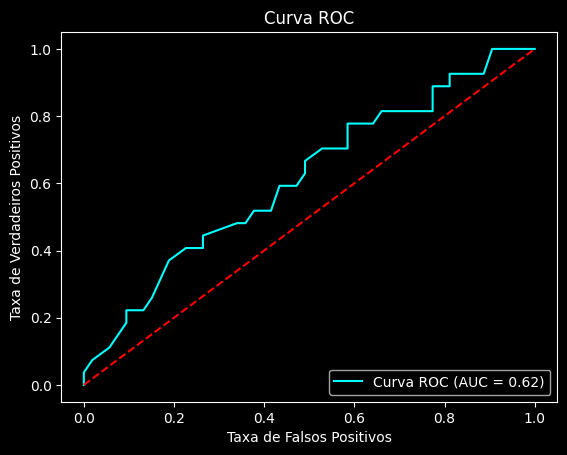

In [62]:
# Plotar a curva ROC
plt.figure()
plt.plot(fpr, tpr, color='cyan', label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.style.use('dark_background')  # Tema dark mode
plt.show()




1. Resumo do Modelo Final
O resumo do modelo final (model_final.summary()) fornece informações importantes sobre o ajuste do modelo. Aqui estão os principais pontos a serem analisados:
a) Coeficientes ((\beta))
* Cada variável no modelo tem um coeficiente associado, que indica o impacto dessa variável na probabilidade de aprovação (admit).
* Interpretação:
    * Um coeficiente positivo significa que um aumento na variável aumenta a probabilidade de aprovação.
    * Um coeficiente negativo significa que um aumento na variável reduz a probabilidade de aprovação.
b) Valores-p (P>|z|)
* Os valores-p indicam a significância estatística de cada variável no modelo.
* Interpretação:
    * Se o valor-p de uma variável for menor que 0.05, ela é considerada estatisticamente significativa.
    * Variáveis com valores-p altos (> 0.05) podem ser removidas do modelo, pois não contribuem significativamente para a previsão.
c) Pseudo R-squared
* O Pseudo R-squared é uma métrica que mede a qualidade do ajuste do modelo.
* Interpretação:
    * Valores mais altos indicam que o modelo explica melhor a variabilidade dos dados.
    * No entanto, o Pseudo R-squared em regressão logística geralmente é menor do que o R-squared em regressão linear.

2. Matriz de Confusão
A matriz de confusão avalia o desempenho do modelo em termos de previsões corretas e incorretas.

Estrutura da Matriz de Confusão:
Classe 0 (Real)	Classe 1 (Real)
Classe 0 (Prevista)	Verdadeiros Negativos (TN)	Falsos Negativos (FN)
Classe 1 (Prevista)	Falsos Positivos (FP)	Verdadeiros Positivos (TP)
Métricas Derivadas:
Acurácia: Proporção de previsões corretas. [ \text{Acurácia} = \frac{TP + TN}{TP + TN + FP + FN} ]
Precisão: Proporção de previsões positivas que são realmente positivas. [ \text{Precisão} = \frac{TP}{TP + FP} ]
Recall (Sensibilidade): Proporção de positivos reais que foram corretamente previstos. [ \text{Recall} = \frac{TP}{TP + FN} ]
F1-Score: Média harmônica entre precisão e recall. [ F1 = 2 \cdot \frac{\text{Precisão} \cdot \text{Recall}}{\text{Precisão} + \text{Recall}} ]


3. Relatório de Classificação
O relatório de classificação (classification_report) fornece as métricas mencionadas acima (Precisão, Recall, F1-Score) para cada classe (0 e 1). Ele ajuda a entender o desempenho do modelo em prever cada classe.

Interpretação:
Classe 0 (Não aprovado):
Alta precisão e recall indicam que o modelo é bom em identificar alunos que não foram aprovados.
Classe 1 (Aprovado):
Alta precisão e recall indicam que o modelo é bom em identificar alunos aprovados.

4. Curva ROC e AUC
A Curva ROC (Receiver Operating Characteristic) avalia a capacidade do modelo de distinguir entre as classes (0 e 1).

Curva ROC:
A curva ROC é um gráfico que mostra a relação entre a Taxa de Verdadeiros Positivos (TPR) e a Taxa de Falsos Positivos (FPR) para diferentes limiares de decisão.
AUC (Área Sob a Curva):
A AUC mede a área sob a curva ROC.
Interpretação:
AUC = 1.0: Modelo perfeito.
AUC = 0.5: Modelo aleatório (sem capacidade de distinção).
Quanto mais próximo de 1, melhor o modelo.


5. Análise Geral
Com base nas estatísticas fornecidas:

Coeficientes e Significância:

Identifique as variáveis mais importantes (com valores-p baixos) e interprete seus coeficientes.
Por exemplo, se gpa tem um coeficiente positivo e significativo, isso indica que notas mais altas aumentam a probabilidade de aprovação.
Desempenho do Modelo:

Avalie a acurácia, precisão, recall e F1-Score para entender o desempenho geral do modelo.
Certifique-se de que o modelo não está enviesado para uma classe (ex.: alta precisão para Classe 0, mas baixa para Classe 1).
Capacidade de Distinção:

Use a curva ROC e o AUC para avaliar a capacidade do modelo de distinguir entre alunos aprovados e não aprovados.
Qualidade do Ajuste:

O Pseudo R-squared e as métricas derivadas da matriz de confusão ajudam a entender o quão bem o modelo se ajusta aos dados.